# 12. Small and Fast Training

Find a way to do fast training based on previous methods. The main speed comes from not using a generator and using smaller datasets.

In [ ]:
import sys
import os
import pandas as pd
import numpy as np

import math
import logging
import gc
import multiprocessing
from functools import partial

from tqdm.notebook import tqdm
from typing import Tuple
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from keras import optimizers
from keras import callbacks

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, precision_recall_fscore_support

import matplotlib.pyplot as plt

2023-02-27 13:28:21.822016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 13:28:22.655258: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-27 13:28:22.655332: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-27 13:28:22.655338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## Load Source Data

In [3]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [4]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

### Functions to prepare the data

In [5]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 

        
    return df_labels

In [6]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

In [7]:
def vectorize_dataset(data: pd.DataFrame, standardize_coordinates: bool=True) -> pd.DataFrame:
    """
    Vectorizes the dataset for deep learning by one-hot encoding and standardizing.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataset to prepare.

    Returns
    -------
    pd.DataFrame
        The vectorized dataset.
    """
    categorical_cols = ['event_name', 'name', 'level', 'fqid', 'room_fqid', 'text_fqid', 'level_group']
    numerical_cols = ['elapsed_time']    
    coordinates_cols = ['room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y']

    df_vectorized = data \
        .drop('session_id', axis=1) \
        .fillna(0)

    # standardize the numerical variables
    df_vectorized[numerical_cols] = (df_vectorized[numerical_cols] - df_vectorized[numerical_cols].mean()) / df_vectorized[numerical_cols].std()

    # standardize the coordinates
    if standardize_coordinates:
        df_vectorized[coordinates_cols] = (df_vectorized[coordinates_cols] - df_vectorized[coordinates_cols].mean()) / df_vectorized[coordinates_cols].std()

    # one-hot encode the categorical variables
    df_vectorized = pd.get_dummies(df_vectorized, columns=categorical_cols)
    
    return df_vectorized

In [8]:
def prepare_sequence_matrix(data: pd.DataFrame, vector_columns: list, standardize_coordinates: bool=True) -> pd.DataFrame:
    """
    Prepare a sequence matrix from a DataFrame for a specific session and level group.

    Parameters
    ----------
    data : pd.DataFrame
        The dataframe containing the data.

    vector_columns : list
        The columns that should appear in the sequence matrix.

    standardize_coordinates : bool, optional
        Whether to standardize the coordinates.

    Returns
    -------
    pd.DataFrame
        The sequence matrix.
    """
    df_sequence_matrix = vectorize_dataset(data, standardize_coordinates=standardize_coordinates)

    # add the missing columns
    missing_columns = [column for column in vector_columns if column not in df_sequence_matrix.columns]
    df_sequence_matrix = pd.concat([
        df_sequence_matrix, 
        pd.DataFrame(columns=missing_columns)], axis=1).fillna(0)

    return df_sequence_matrix[vector_columns]

### Functions to create datasets

In [9]:
def create_vector_array(session_data: pd.DataFrame, 
                        level_group: int,
                        event_count:int = 1000) -> np.array:
    """
    Creates a vector array for a specific session and question number.
    """
    # get the data for the session and level group
    df_session = session_data.query('level_group == @level_group')

    # prepare the sequence matrix
    df_sequence_matrix = prepare_sequence_matrix(df_session, vector_columns)

    # convert it to a numpy array
    vector_array = df_sequence_matrix.to_numpy()

    # the array cannot have more events than the event count
    vector_array = vector_array[:event_count]

    # pad the array with zeros if it has less events than the event count
    if vector_array.shape[0] < event_count:
        vector_array = np.pad(vector_array, ((0, event_count - vector_array.shape[0]), (0, 0)), 'constant')

    del df_session
    del df_sequence_matrix

    return vector_array

In [10]:
def create_dataset(X: pd.DataFrame,
                   y: pd.DataFrame,
                   event_count:int,
                   session_list: list) -> Tuple[np.array, np.array]:
    """
    Creates a dataset for a specific set of sessions and question numbers.

    Parameters
    ----------
    X : pd.DataFrame
        The main dataset.

    y : pd.DataFrame
        The label dataset.

    event_count : int
        The number of events to include in the dataset.

    session_ids : list
        The list of session ids.

    Returns
    -------
    Tuple[np.array, np.array]
        The dataset and the labels.
    """
    X_dataset = []
    y_dataset = []

    for session_id in session_list:
        # get the session labels
        df_session_labels = y.query('session_id == @session_id')
        df_session = X.query('session_id == @session_id')

        # create the level groups
        vector_arrays = {
            '0-4': create_vector_array(df_session, '0-4', event_count),
            '5-12': create_vector_array(df_session, '5-12', event_count),
            '13-22': create_vector_array(df_session, '13-22', event_count),
        }

        # iterate over all the questions answered in the session
        for _, row in df_session_labels.iterrows():
            question_number = row['question_num']
            correct = row['correct']
            level_group = map_question_to_level_group(question_number)

            # get the vector array
            vector_array = vector_arrays[level_group].copy()

            # set the question number value
            column_index = vector_columns.index(f'question_{question_number}')
            #print(f'Question: {question_number}, Column: {column_index}')
            vector_array[:, column_index] = 1

            # add the vector array to the dataset
            X_dataset.append(vector_array)
            del vector_array

            # add the label to the dataset
            y_dataset.append(correct)

    X_out = np.array(X_dataset, dtype=np.float64)
    y_out = np.array(y_dataset)

    return X_out, y_out

### Functions for Model Training

In [11]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [12]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()from sklearn.metrics import f1_score

In [13]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray) -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [14]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [15]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray) -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [16]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    return test_model(model, history, X_test, y_test)

In [17]:
def global_train_model(model,
                       epochs: int,
                       batch_size: int,
                       optimizer,
                       loss: str,
                       metrics: list,
                       class_weight: dict=None) -> float:
        """
        Train the model using the global data.

        Parameters
        ----------
        model : keras.models
                The model to train.
        epochs : int
                The number of epochs.
        batch_size : int
                The batch size.
        optimizer : keras.optimizers
                The optimizer.
        loss : str
                The loss function.
        metrics : list
                The metrics.
        class_weight : dict
                The class weights.

        Returns
        -------
        float
                The optimized threshold for the best F1 score.
        """
        global X_train
        global y_train
        global X_val
        global y_val
        global X_test
        global y_test

        return train_and_test_model(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                X_test=X_test,
                y_test=y_test,
                epochs=epochs,
                batch_size=batch_size,
                optimizer=optimizer,
                loss=loss,
                metrics=metrics,
                class_weight=class_weight)

## Pre-process Data

### Pre-defined Values

In [18]:
vector_columns = [
    'elapsed_time', 
    'room_coor_x', 
    'room_coor_y', 
    'screen_coor_x', 
    'screen_coor_y', 
    'event_name_checkpoint', 
    'event_name_cutscene_click', 
    'event_name_map_click', 
    'event_name_map_hover', 
    'event_name_navigate_click', 
    'event_name_notebook_click', 
    'event_name_notification_click', 
    'event_name_object_click', 
    'event_name_object_hover', 
    'event_name_observation_click', 
    'event_name_person_click', 
    'name_basic', 
    'name_close', 
    'name_next', 
    'name_open', 
    'name_prev', 
    'name_undefined', 
    'level_0', 
    'level_1', 
    'level_2', 
    'level_3', 
    'level_4', 
    'level_5', 
    'level_6', 
    'level_7', 
    'level_8', 
    'level_9', 
    'level_10', 
    'level_11', 
    'level_12', 
    'level_13', 
    'level_14', 
    'level_15', 
    'level_16', 
    'level_17', 
    'level_18', 
    'level_19', 
    'level_20', 
    'level_21', 
    'level_22', 
    'level_group_0-4', 
    'level_group_13-22', 
    'level_group_5-12', 
    'question_1',
    'question_2',
    'question_3',
    'question_4',
    'question_5',
    'question_6',
    'question_7',
    'question_8',
    'question_9',
    'question_10',
    'question_11',
    'question_12',
    'question_13',
    'question_14',
    'question_15',
    'question_16',
    'question_17',
    'question_18',    
]

### Perform Pre-Processing

In [19]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [20]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


In [21]:
gc.collect()

50

## Parameters

In [22]:
epochs = 20

loss = 'binary_crossentropy'
metrics = ['accuracy']

In [23]:
random_state = 51

sample_size = 2000
event_count = 200
batch_size = 64

## Data Selection

In [24]:
# select all the unique session ids
all_session_ids = df_source_labels['session_id'].unique()
print('All Session IDs:', len(all_session_ids))

# create a sample for testing
session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)
print('Sample Session IDs:', len(session_ids))

All Session IDs: 11779
Sample Session IDs: 2000


In [25]:
# split the dataset into train, validation and test sets
train, test = train_test_split(session_ids, test_size=0.3)
test, val = train_test_split(test, test_size=0.5)

# print the number of sessions in each set
print(f'Train: {len(train)}')
print(f'Validation: {len(val)}')
print(f'Test: {len(test)}')

Train: 1400
Validation: 300
Test: 300


## Create Datasets

In [26]:
# create the training dataset
X_train, y_train = create_dataset(
    X=df_source, y=df_source_labels, session_list=train, event_count=event_count)
gc.collect()

45

In [27]:
# create the validation dataset
X_val, y_val = create_dataset(
    X=df_source, y=df_source_labels, session_list=val, event_count=event_count)
gc.collect()

90

In [28]:
# create the test dataset
X_test, y_test = create_dataset(
    X=df_source, y=df_source_labels, session_list=test, event_count=event_count)
gc.collect()

90

## Model Training

In [29]:
model = Sequential()
model.add(layers.LSTM(32, input_shape=(event_count, len(vector_columns))))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-27 12:59:44.805288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:59:44.818068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:59:44.818222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 12:59:44.818839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/20


2023-02-27 12:59:47.961513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


 10/394 [..............................] - ETA: 2s - loss: 0.7025 - accuracy: 0.5125   

2023-02-27 12:59:48.440934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


394/394 [==============================] - 5s 8ms/step - loss: 0.6263 - accuracy: 0.6628 - val_loss: 0.5636 - val_accuracy: 0.7091
Epoch 2/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5519 - accuracy: 0.7248 - val_loss: 0.5239 - val_accuracy: 0.7404
Epoch 3/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5357 - accuracy: 0.7342 - val_loss: 0.5150 - val_accuracy: 0.7426
Epoch 4/20
394/394 [==============================] - 2s 6ms/step - loss: 0.5303 - accuracy: 0.7371 - val_loss: 0.5122 - val_accuracy: 0.7467
Epoch 5/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5271 - accuracy: 0.7381 - val_loss: 0.5102 - val_accuracy: 0.7441
Epoch 6/20
394/394 [==============================] - 3s 6ms/step - loss: 0.5243 - accuracy: 0.7401 - val_loss: 0.5095 - val_accuracy: 0.7439
Epoch 7/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5246 - accuracy: 0.7418 - val_loss: 0.5091 - val_accuracy: 0.7443
Epoch 8/20
394/39

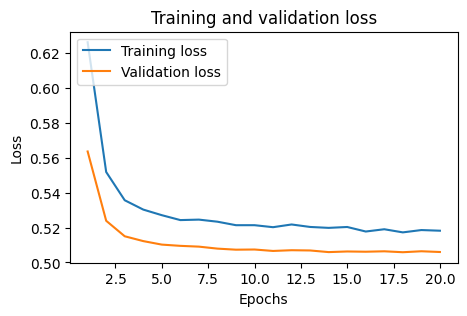

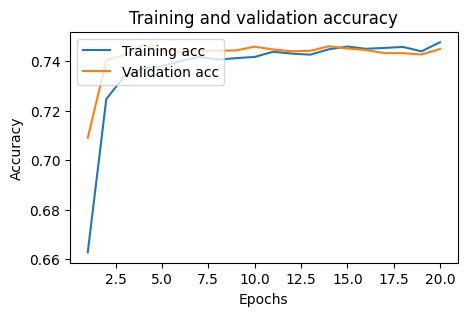

169/169 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.49      0.63      0.55      1573
           1       0.83      0.73      0.77      3827

    accuracy                           0.70      5400
   macro avg       0.66      0.68      0.66      5400
weighted avg       0.73      0.70      0.71      5400

Optimized threshold for best F1: 0.69


0.6900000000000001

In [30]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

### Increase model complexity (first layer units)

#### 64 Units

In [31]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(event_count, len(vector_columns))))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/20
394/394 [==============================] - 4s 8ms/step - loss: 0.6000 - accuracy: 0.6893 - val_loss: 0.5307 - val_accuracy: 0.7320
Epoch 2/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5322 - accuracy: 0.7339 - val_loss: 0.5122 - val_accuracy: 0.7435
Epoch 3/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5242 - accuracy: 0.7385 - val_loss: 0.5094 - val_accuracy: 0.7457
Epoch 4/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5232 - accuracy: 0.7398 - val_loss: 0.5072 - val_accuracy: 0.7452
Epoch 5/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5229 - accuracy: 0.7419 - val_loss: 0.5064 - val_accuracy: 0.7452
Epoch 6/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5204 - accuracy: 0.7431 - val_loss: 0.5060 - val_accuracy: 0.7457
Epoch 7/20
394/394 [==============================] - 3s 7ms/step - loss: 0.5200 - accuracy: 0.7414 - val_loss: 0.5055 - val_accuracy: 0.7452
Epoch 

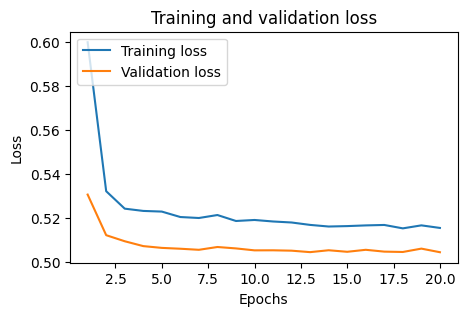

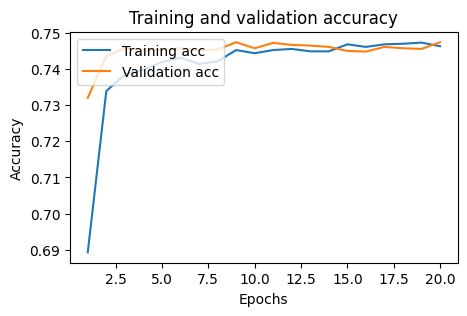

169/169 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1573
           1       0.82      0.76      0.79      3827

    accuracy                           0.71      5400
   macro avg       0.66      0.67      0.66      5400
weighted avg       0.73      0.71      0.72      5400

Optimized threshold for best F1: 0.66


0.66

In [32]:
global_train_model(
    model=model,
    epochs=epochs,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

### Try a diffeten optimizer

In [33]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(event_count, len(vector_columns))))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/30
394/394 [==============================] - 4s 8ms/step - loss: 0.5851 - accuracy: 0.7070 - val_loss: 0.5167 - val_accuracy: 0.7448
Epoch 2/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5258 - accuracy: 0.7383 - val_loss: 0.5087 - val_accuracy: 0.7457
Epoch 3/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5226 - accuracy: 0.7404 - val_loss: 0.5060 - val_accuracy: 0.7467
Epoch 4/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5215 - accuracy: 0.7401 - val_loss: 0.5062 - val_accuracy: 0.7474
Epoch 5/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5214 - accuracy: 0.7425 - val_loss: 0.5059 - val_accuracy: 0.7467
Epoch 6/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5205 - accuracy: 0.7441 - val_loss: 0.5066 - val_accuracy: 0.7496
Epoch 7/30
394/394 [==============================] - 3s 7ms/step - loss: 0.5190 - accuracy: 0.7464 - val_loss: 0.5054 - val_accuracy: 0.7481
Epoch 

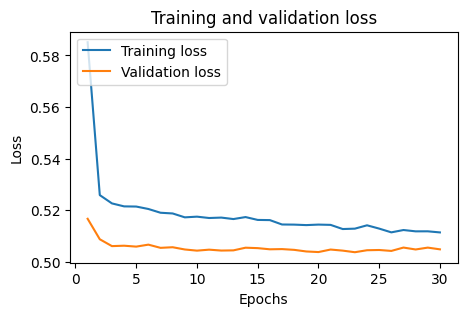

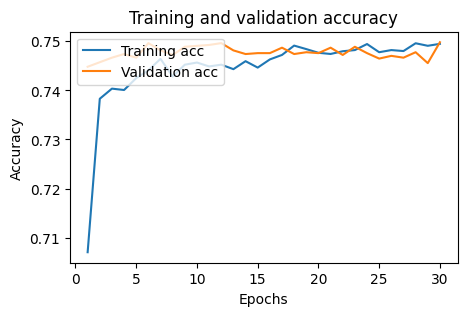

169/169 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.50      0.59      0.54      1573
           1       0.82      0.76      0.79      3827

    accuracy                           0.71      5400
   macro avg       0.66      0.67      0.67      5400
weighted avg       0.73      0.71      0.72      5400

Optimized threshold for best F1: 0.65


0.65

In [34]:
global_train_model(
    model=model,
    epochs=30,
    batch_size=batch_size,
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

## Increase Data Size

In [25]:
def select_sessions(
        y: pd.DataFrame,
        sample_size: int,
        random_state: int=1337) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Selects a sample of sessions from the dataset.

    Parameters
    ----------
    y : pd.DataFrame
        The label dataset.
    sample_size : int
        The number of sessions to select.
    random_state : int
        The random state to use.

    Returns
    -------
    Tuple[np.ndarray, np.ndarray, np.ndarray]
        The selected session ids, the main dataset and the label dataset.
    """
    # select all the unique session ids
    all_session_ids = y['session_id'].unique()

    # create a sample for testing
    session_ids = np.random.choice(all_session_ids, size=sample_size, replace=False)

    # split the dataset into train, validation and test sets
    train, test = train_test_split(session_ids, test_size=0.3)
    test, val = train_test_split(test, test_size=0.5)

    # print the number of sessions in each set
    print(f'Train: {len(train)}')
    print(f'Validation: {len(val)}')
    print(f'Test: {len(test)}')

    return train, val, test

In [26]:
# select a sample of sessions
train, val, test = select_sessions(y=df_source_labels, sample_size=4000, random_state=random_state)

# create the training dataset
X_train, y_train = create_dataset(
    X=df_source, y=df_source_labels, session_list=train, event_count=event_count)
gc.collect()

# create the validation dataset
X_val, y_val = create_dataset(
    X=df_source, y=df_source_labels, session_list=val, event_count=event_count)
gc.collect()

# create the test dataset
X_test, y_test = create_dataset(
    X=df_source, y=df_source_labels, session_list=test, event_count=event_count)
gc.collect()

Train: 2800
Validation: 600
Test: 600


45

### Retry Last Model

In [27]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(event_count, len(vector_columns))))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-27 13:33:14.322122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 13:33:14.383632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 13:33:14.383769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-27 13:33:14.384444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [28]:
global_train_model(
    model=model,
    epochs=30,
    batch_size=batch_size,
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=metrics)

2023-02-27 13:33:15.475154: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2661120000 exceeds 10% of free system memory.
2023-02-27 13:33:16.627989: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 2661120000 exceeds 10% of free system memory.


Epoch 1/30


2023-02-27 13:33:19.361411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


  9/788 [..............................] - ETA: 5s - loss: 0.6758 - accuracy: 0.5781   

2023-02-27 13:33:20.253252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


788/788 [==============================] - 9s 7ms/step - loss: 0.5598 - accuracy: 0.7128 - val_loss: 0.5273 - val_accuracy: 0.7336
Epoch 2/30
648/788 [=======================>......] - ETA: 0s - loss: 0.5267 - accuracy: 0.7336

KeyboardInterrupt: 

### Try Class Weights

In [ ]:
model = Sequential()
model.add(layers.LSTM(64, input_shape=(event_count, len(vector_columns))))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
class_weight = {0: 1.5, 1: 1.0}

global_train_model(
    model=model,
    epochs=30,
    batch_size=batch_size,
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=loss,
    metrics=metrics,
    class_weight=class_weight)

2023-02-27 13:27:43.656212: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB (rounded to 2661120000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-27 13:27:43.656259: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-27 13:27:43.656272: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 93, Chunks in use: 93. 23.2KiB allocated for chunks. 23.2KiB in use in bin. 3.9KiB client-requested in use in bin.
2023-02-27 13:27:43.656279: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 1, Chunks in use: 0. 512B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2023-02-27 13:27:43.656286: I tensorflow/tsl/framework/bfc_alloca

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.